In [1]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
import seaborn as sns

In [2]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'

In [3]:
def get_picks(data):
    # get valid channels
    ch_name_picks = mne.pick_channels_regexp(data.ch_names, regexp='M[LRZ]...-4503')
    type_picks = mne.pick_types(data.info, meg=True)
    picks= np.intersect1d(ch_name_picks, type_picks)
    
    return picks

In [4]:
# load data
hc_post = pd.read_pickle(pjoin(results_pth, 'hc_post.pickle'))

# picks ref
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root=post_root)
raw_sub = mne_bids.read_raw_bids(sub_path)
picks = get_picks(raw_sub)

Opening raw data file /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 557999 =      0.000 ...   929.998 secs
Ready.
Current compensation grade : 3
Reading events from /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_events.tsv.
Reading channel info from /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_channels.tsv.


In [11]:
# get sensor indices for homotopic and heterotopic sensor pairs
ch_name = list(np.array(raw_sub.ch_names)[picks])

opp = {'L':'R', 'R':'L'}

sym_ch_pairs = {}
asym_ch_pairs = {}
for ch1 in ch_name:
    if ch1[1] != 'Z':
        ch_opp = ch1.replace(ch1[1], opp[ch1[1]])
        if ch_opp in ch_name:
            sym_ch_pairs[ch_name.index(ch1)] = ch_name.index(ch_opp)
            ch_opp_lobe = [i for i in np.arange(len(ch_name)) if (ch_name[i][1]==opp[ch1[1]] and ch_name[i]!=ch_opp)]
            
            asym_ch_pairs[ch_name.index(ch1)] = np.asarray(ch_opp_lobe)

In [12]:
# sort coorelation values for homotopic and heterotopic groups
sym_corr = {i: 0 for i in sym_ch_pairs.keys()}
asym_corr = {i: 0 for i in asym_ch_pairs.keys()}

count = 0
for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list
        
    for run in run_ls: 
        for i in sym_corr.keys():
            sym = hc_post[sub][run][i, sym_ch_pairs[i]]
            sym_corr[i] += sym
            
        for i in asym_corr.keys():    
            asym = hc_post[sub][run][[i]*len(asym_ch_pairs[i]), asym_ch_pairs[i]].mean()
            asym_corr[i] += asym
        count += 1

sym_corr_arr = np.asarray(list(sym_corr.values())) / count
asym_corr_arr = np.asarray(list(asym_corr.values())) / count

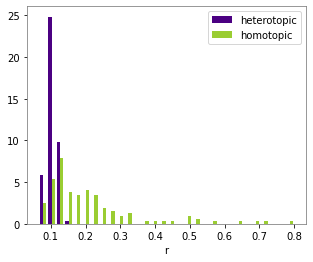

In [13]:
# plot fig A
fig,ax = plt.subplots(figsize=[5,4])
_,_,_ = ax.hist([asym_corr_arr, sym_corr_arr], bins=30, density=True, 
                 label=['heterotopic', 'homotopic'], color=['indigo', 'yellowgreen'])
plt.legend()
plt.xlabel('r')
[ax.spines[i].set_color('gray') for i in ['top', 'bottom', 'left', 'right']]

fig.savefig(pjoin(results_pth, 'mirror_hist.jpg'), dpi=300)

In [14]:
def plot_topomap(val, meg_layout, vmin=None, vmax=None, title=None):
    """
    input params: val: [n_chn(272), 1]
                  meg_layout: mne Layout instance
                  title: str, title for plot, default to None
    """
    
    pos = meg_layout.pos[:,:2]
    x_min = np.min(pos[:,0])
    x_max = np.max(pos[:,0])
    y_min = np.min(pos[:,1])
    y_max = np.max(pos[:,1])
    center_x = (x_min + x_max)/2
    center_y = (y_min + y_max)/2
    layout_pos = np.zeros(pos.shape)
    for i, coor in enumerate(pos):
        layout_pos[i,0] = coor[0] - center_x
        layout_pos[i,1] = coor[1] - center_y
    
    if vmin is None:
        vmin=np.percentile(val, 2)
    if vmax is None:
        vmax=np.percentile(val, 98)
    
    fig = plt.figure()
    if title is not None:
        plt.title(title)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'))
    mne.viz.plot_topomap(val, layout_pos, vmin=vmin, vmax=vmax, cmap='viridis', sphere=np.array([0,0,0,0.5]))
    
    return fig

In [15]:
# extract layout
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root=post_root)
raw_sub = mne_bids.read_raw_bids(sub_path)
meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg')

intercorr_chn = []
ch_name_picks = mne.pick_channels_regexp(raw_sub.ch_names, regexp='M[LRZ]...-4503')
type_picks = mne.pick_types(raw_sub.info, meg=True)
picks= np.intersect1d(ch_name_picks, type_picks)
for idx in picks:
    intercorr_chn.append(raw_sub.ch_names[idx][:5])
exclude_list = [x for x in meg_layout.names if x not in intercorr_chn]
bad_ch = ['MRF55', 'MLT23', 'MLT16']
for ch in bad_ch:
    exclude_list.append(ch)

Opening raw data file /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 557999 =      0.000 ...   929.998 secs
Ready.
Current compensation grade : 3
Reading events from /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_events.tsv.
Reading channel info from /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/derivatives/preproc_meg-mne_mri-fmriprep/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_channels.tsv.


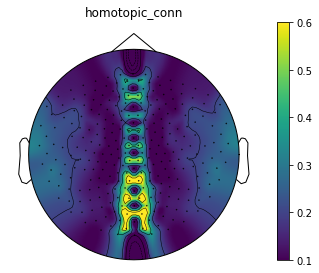

In [16]:
# plot fig B
meg_layout = mne.channels.find_layout(raw_sub.info, ch_type='meg', exclude=exclude_list)

data_plot = np.zeros(len(meg_layout.names))
for i in sym_ch_pairs.keys():
    data_plot[np.where(np.asarray(meg_layout.names) == ch_name[i][:-5])[0][0]] = sym_corr[i] / count
    
fig = plot_topomap(data_plot, meg_layout, vmin= 0.1, vmax=0.6, title='homotopic_conn')
# fig.savefig(pjoin(results_pth, 'mirror_topo.jpg'), dpi=300)